In [0]:
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer
import seaborn as sns
import pandas as pd
import numpy as np
import mlflow
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

In [0]:
# Carregamento do arquivo CSV para um DataFrame do Spark
df = spark.read.format("csv")\
                .option("header", "true")\
                .load("dbfs:/FileStore/shared_uploads/joselvanin@gmail.com/Stars.csv")

In [0]:
# Exibição de 10 linhas do DataFrame
df.show(n=10)

+-----------+--------+------+-----+-----+--------------+----+
|Temperature|       L|     R|  A_M|Color|Spectral_Class|Type|
+-----------+--------+------+-----+-----+--------------+----+
|       3068|  0.0024|  0.17|16.12|  Red|             M|   0|
|       3042|  0.0005|0.1542| 16.6|  Red|             M|   0|
|       2600|  0.0003| 0.102| 18.7|  Red|             M|   0|
|       2800|  0.0002|  0.16|16.65|  Red|             M|   0|
|       1939|0.000138| 0.103|20.06|  Red|             M|   0|
|       2840| 0.00065|  0.11|16.98|  Red|             M|   0|
|       2637| 0.00073| 0.127|17.22|  Red|             M|   0|
|       2600|  0.0004| 0.096| 17.4|  Red|             M|   0|
|       2650| 0.00069|  0.11|17.45|  Red|             M|   0|
|       2700| 0.00018|  0.13|16.05|  Red|             M|   0|
+-----------+--------+------+-----+-----+--------------+----+
only showing top 10 rows



In [0]:
# Exibição do esquema do DataFrame
df.printSchema()

root
 |-- Temperature: string (nullable = true)
 |-- L: string (nullable = true)
 |-- R: string (nullable = true)
 |-- A_M: string (nullable = true)
 |-- Color: string (nullable = true)
 |-- Spectral_Class: string (nullable = true)
 |-- Type: string (nullable = true)



In [0]:
# verifica valores nulos em todas as colunas
df.select([count(when(isnull(c), c))\
               .alias(c) for c in df.columns])\
               .show()

+-----------+---+---+---+-----+--------------+----+
|Temperature|  L|  R|A_M|Color|Spectral_Class|Type|
+-----------+---+---+---+-----+--------------+----+
|          0|  0|  0|  0|    0|             0|   0|
+-----------+---+---+---+-----+--------------+----+



In [0]:
# Conversão de colunas para tipo double
col_list = ['Temperature', 'L', 'R', 'A_M']

for c in col_list:
    df = df.withColumn(c, col(c).cast("double"))

In [0]:
# Função StringIndexer para converter valores categóricos (strings) em valores numéricos

# Define o StringIndexer para a coluna 'Color'
color_indexer = StringIndexer(inputCol="Color", outputCol="ColorIndex")
df = color_indexer.fit(df).transform(df)

# Define o StringIndexer para a coluna 'Spectral_Class'
spectral_indexer = StringIndexer(inputCol="Spectral_Class", outputCol="SpectralIndex")
df = spectral_indexer.fit(df).transform(df)

# Define o StringIndexer para a coluna 'Color'
Type_indexer = StringIndexer(inputCol="Type", outputCol="TypeIndex")
df = Type_indexer.fit(df).transform(df)

In [0]:
# Remove as colunas com valores categóricos. O resultado é atribuído ao próprio DataFrame
df = df.drop("Type", "Color", "Spectral_Class")

In [0]:
# Exibe os primeiros registros do DataFrame 
df.show(n=10)

+-----------+-------+------+-----+----------+-------------+---------+
|Temperature|      L|     R|  A_M|ColorIndex|SpectralIndex|TypeIndex|
+-----------+-------+------+-----+----------+-------------+---------+
|     3068.0| 0.0024|  0.17|16.12|       0.0|          0.0|      0.0|
|     3042.0| 5.0E-4|0.1542| 16.6|       0.0|          0.0|      0.0|
|     2600.0| 3.0E-4| 0.102| 18.7|       0.0|          0.0|      0.0|
|     2800.0| 2.0E-4|  0.16|16.65|       0.0|          0.0|      0.0|
|     1939.0|1.38E-4| 0.103|20.06|       0.0|          0.0|      0.0|
|     2840.0| 6.5E-4|  0.11|16.98|       0.0|          0.0|      0.0|
|     2637.0| 7.3E-4| 0.127|17.22|       0.0|          0.0|      0.0|
|     2600.0| 4.0E-4| 0.096| 17.4|       0.0|          0.0|      0.0|
|     2650.0| 6.9E-4|  0.11|17.45|       0.0|          0.0|      0.0|
|     2700.0| 1.8E-4|  0.13|16.05|       0.0|          0.0|      0.0|
+-----------+-------+------+-----+----------+-------------+---------+
only showing top 10 

In [0]:
# Converte o DataFrame do PySpark para um DataFrame do Pandas
df_p = df.toPandas()

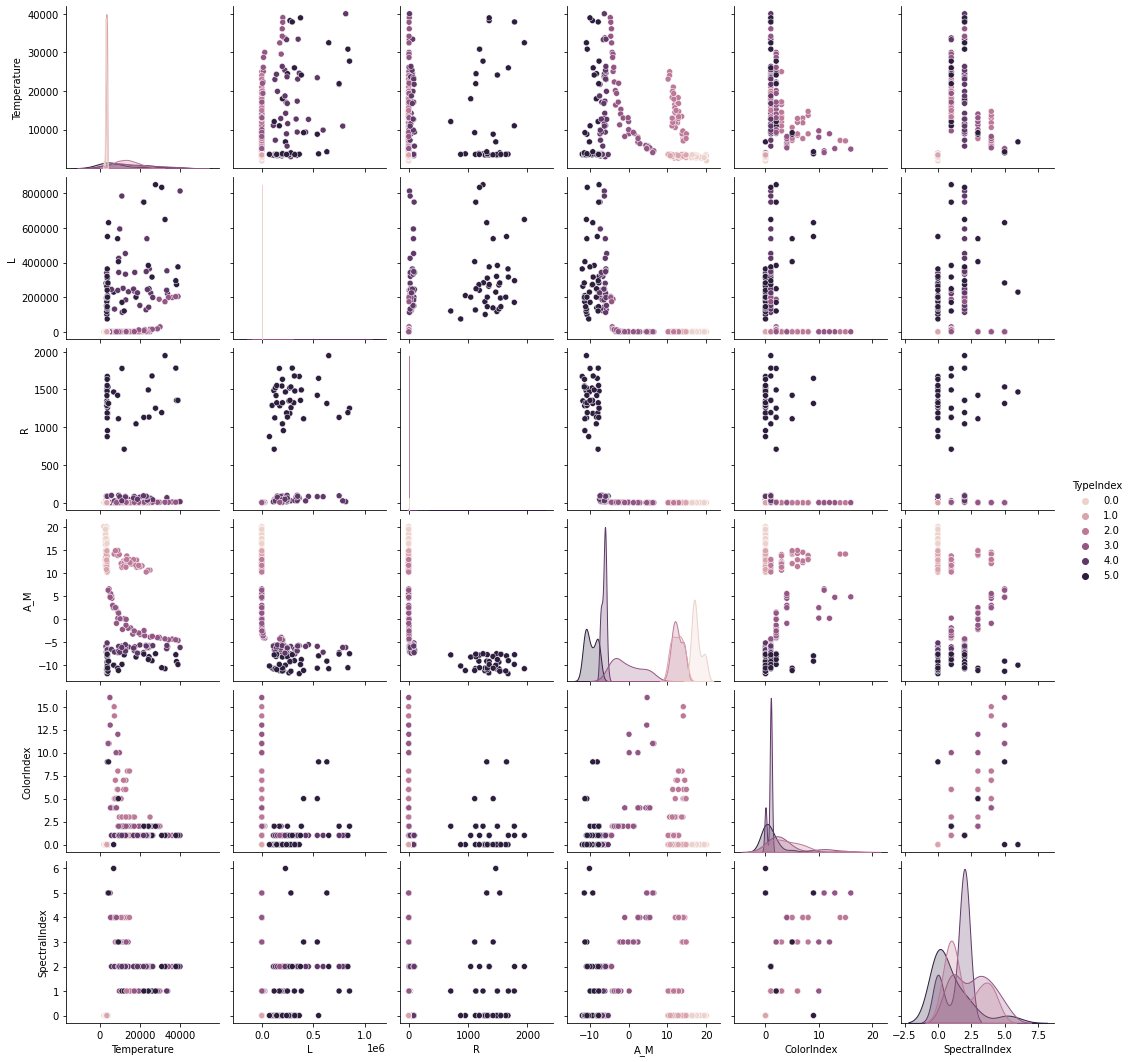

In [0]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Gráfico para explorar a relação entre variáveis e detectar padrões
sns.pairplot(data=df_p, hue='TypeIndex'); 

In [0]:
# Converte um DataFrame do Pandas para um array numpy
df_np = df_p.to_numpy()

In [0]:
# Imprime as dimensões do array
print(df_np.shape)

(240, 7)


In [0]:
# Separa as classes do DataFrame
x = df_np[:,0:-1] # Seleciona todas as linhas da primeira coluna até a penúltima.

y = df_np[:,-1] # Seleciona todas as linhas da última coluna.

# Imprime a forma dos arrays
print(x.shape)
print(y.shape)

(240, 6)
(240,)


In [0]:
# Normaliza as colunas do array
for i in range(6):
    x[:, i] = x[:, i] / np.max(x[:, i]) # Divide cada elemento da coluna pelo valor máximo da coluna.

In [0]:
# "to_categorical" converte uma série de valores inteiros em uma matriz binária.

y = to_categorical(y, num_classes=6) #  Número de classes.

print(y)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [0]:
# Divide os dados em conjuntos de treinamento e teste
from sklearn.model_selection import train_test_split

# 'test_size' especifica que 20% dos dados serão usados como conjunto de teste.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [0]:
# Define um modelo sequencial do Keras
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)), # Indica o número de features ou colunas no conjunto de dados de treinamento.
    Dense(64, activation='relu'), # Camada densa com 64 unidades de ativação relu
    Dense(6, activation='softmax') # Camada densa com 6 unidades e ativação softmax
])
# O softmax é usado para garantir que a saída seja uma probabilidade para cada uma das 6 classes

In [0]:
# Configurar a compilação do modelo antes do treinamento.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# "optimizer" é usado para atualizar os pesos do modelo durante o treinamento.
# "loss" especifica a função de perda é usada para avaliar a precisão do modelo durante o treinamento.
# "categorical_crossentropy", é uma função de perda para problemas de classificação multi-classe.
# "metrics" é uma lista de métricas que sera usadas para avaliar

In [0]:
# Treina o modelo de rede neural construído com a biblioteca Keras
model.fit(x_train, y_train, epochs=50, batch_size=32)

#  "epochs" especifica o número de vezes que o conjunto de dados será passado pelo modelo durante o treinamento. 
#  "batch_size" especifica o número de amostras por atualização dos pesos do modelo durante o treinamento. 

Epoch 1/50
6/6 [==============================] - 1s 3ms/step - loss: 1.7806 - accuracy: 0.1823
Epoch 2/50
6/6 [==============================] - 0s 4ms/step - loss: 1.7054 - accuracy: 0.4583
Epoch 3/50
6/6 [==============================] - 0s 2ms/step - loss: 1.6379 - accuracy: 0.6198
Epoch 4/50
6/6 [==============================] - 0s 3ms/step - loss: 1.5745 - accuracy: 0.7083
Epoch 5/50
6/6 [==============================] - 0s 2ms/step - loss: 1.5031 - accuracy: 0.7552
Epoch 6/50
6/6 [==============================] - 0s 2ms/step - loss: 1.4295 - accuracy: 0.7604
Epoch 7/50
6/6 [==============================] - 0s 2ms/step - loss: 1.3492 - accuracy: 0.7604
Epoch 8/50
6/6 [==============================] - 0s 2ms/step - loss: 1.2660 - accuracy: 0.7656
Epoch 9/50
6/6 [==============================] - 0s 8ms/step - loss: 1.1771 - accuracy: 0.7656
Epoch 10/50
6/6 [==============================] - 0s 3ms/step - loss: 1.0897 - accuracy: 0.7708
Epoch 11/50
6/6 [======================

In [0]:
#  Avalia o desempenho do modelo criado.
loss, accuracy = model.evaluate(x_test, y_test) # Evaluate() é usado para avaliar o modelo com os dados de teste
print('Test loss:', loss) # loss (perda) 
print('Test accuracy:', accuracy) # accuracy (precisão)

2/2 [==============================] - 0s 6ms/step - loss: 0.1829 - accuracy: 0.9792
Test loss: 0.18290971219539642
Test accuracy: 0.9791666865348816
